# Neural Optimal Transport (NOT) for Weak Costs [Seminar]
The seminar is prepared by [Alexander Korotin](https://scholar.google.ru/citations?user=1rIIvjAAAAAJ). This is a stand-alone Google Colab implementation (pytorch). Both CPU & GPU supported.

**Terms of use.** I give my permission to use this seminar for educational purposes but only "as is", i.e., without any changes. If you have found a misprint/mistake or have a suggestion regarding improving the seminar, please leave a comment in the repository.

In this seminar, you will learn how to:
- [Theoretical part] Derive the duality formula for weak transport costs;
- [Practical part] Implement [NOT algorithm](https://arxiv.org/abs/2201.12220) for weak costs:
  - On toy 2D examples;
  - On a simple unpaired image-to-image translation task;

Before solving this seminar, it is recommended to complete the [analogous seminar](https://github.com/iamalexkorotin/NeuralOptimalTransport/blob/main/seminars/NOT_seminar_strong.ipynb) for strong OT costs.

**Related works** to consider:
  - *Neural Optimal Transport* [paper](https://arxiv.org/abs/2201.12220) and [github](https://github.com/iamalexkorotin/NeuralOptimalTransport) (ICLR 2023 spotlight);
  - *Kernel Neural Optimal Transport* [paper](https://arxiv.org/abs/2205.15269) and [github](https://github.com/iamalexkorotin/KernelNeuralOptimalTransport) (ICLR 2023);

## 0. Warmup part. Weak OT formulation

**Kantorovich's OT (strong OT) formulation.**
For a pair of probability distributions $\mathbb{P}, \mathbb{Q}$ on spaces $\mathcal{X}$, $\mathcal{Y}$, respectively, and a cost function $c:\mathcal{X}\times\mathcal{Y}\rightarrow \mathbb{R}$, the Kantorovich's formulation of OT is
$$\text{Cost}(\mathbb{P},\mathbb{Q})=\inf_{{\color{blue}\pi}\in\Pi(\mathbb{P},\mathbb{Q})}\int_{\mathcal{X}\times\mathcal{Y}}c(x,y)d{\color{blue}\pi}(x,y),$$
where the $\inf$ is taken over the distributions ${\color{blue}\pi}\in \mathcal{P}(\mathcal{X}\times\mathcal{Y})$ whose marginals are ${\color{blue}\pi}_x=\mathbb{P}$ and ${\color{blue}\pi}_y=\mathbb{Q}$ (**transport plans**).

<img width=320 src=" 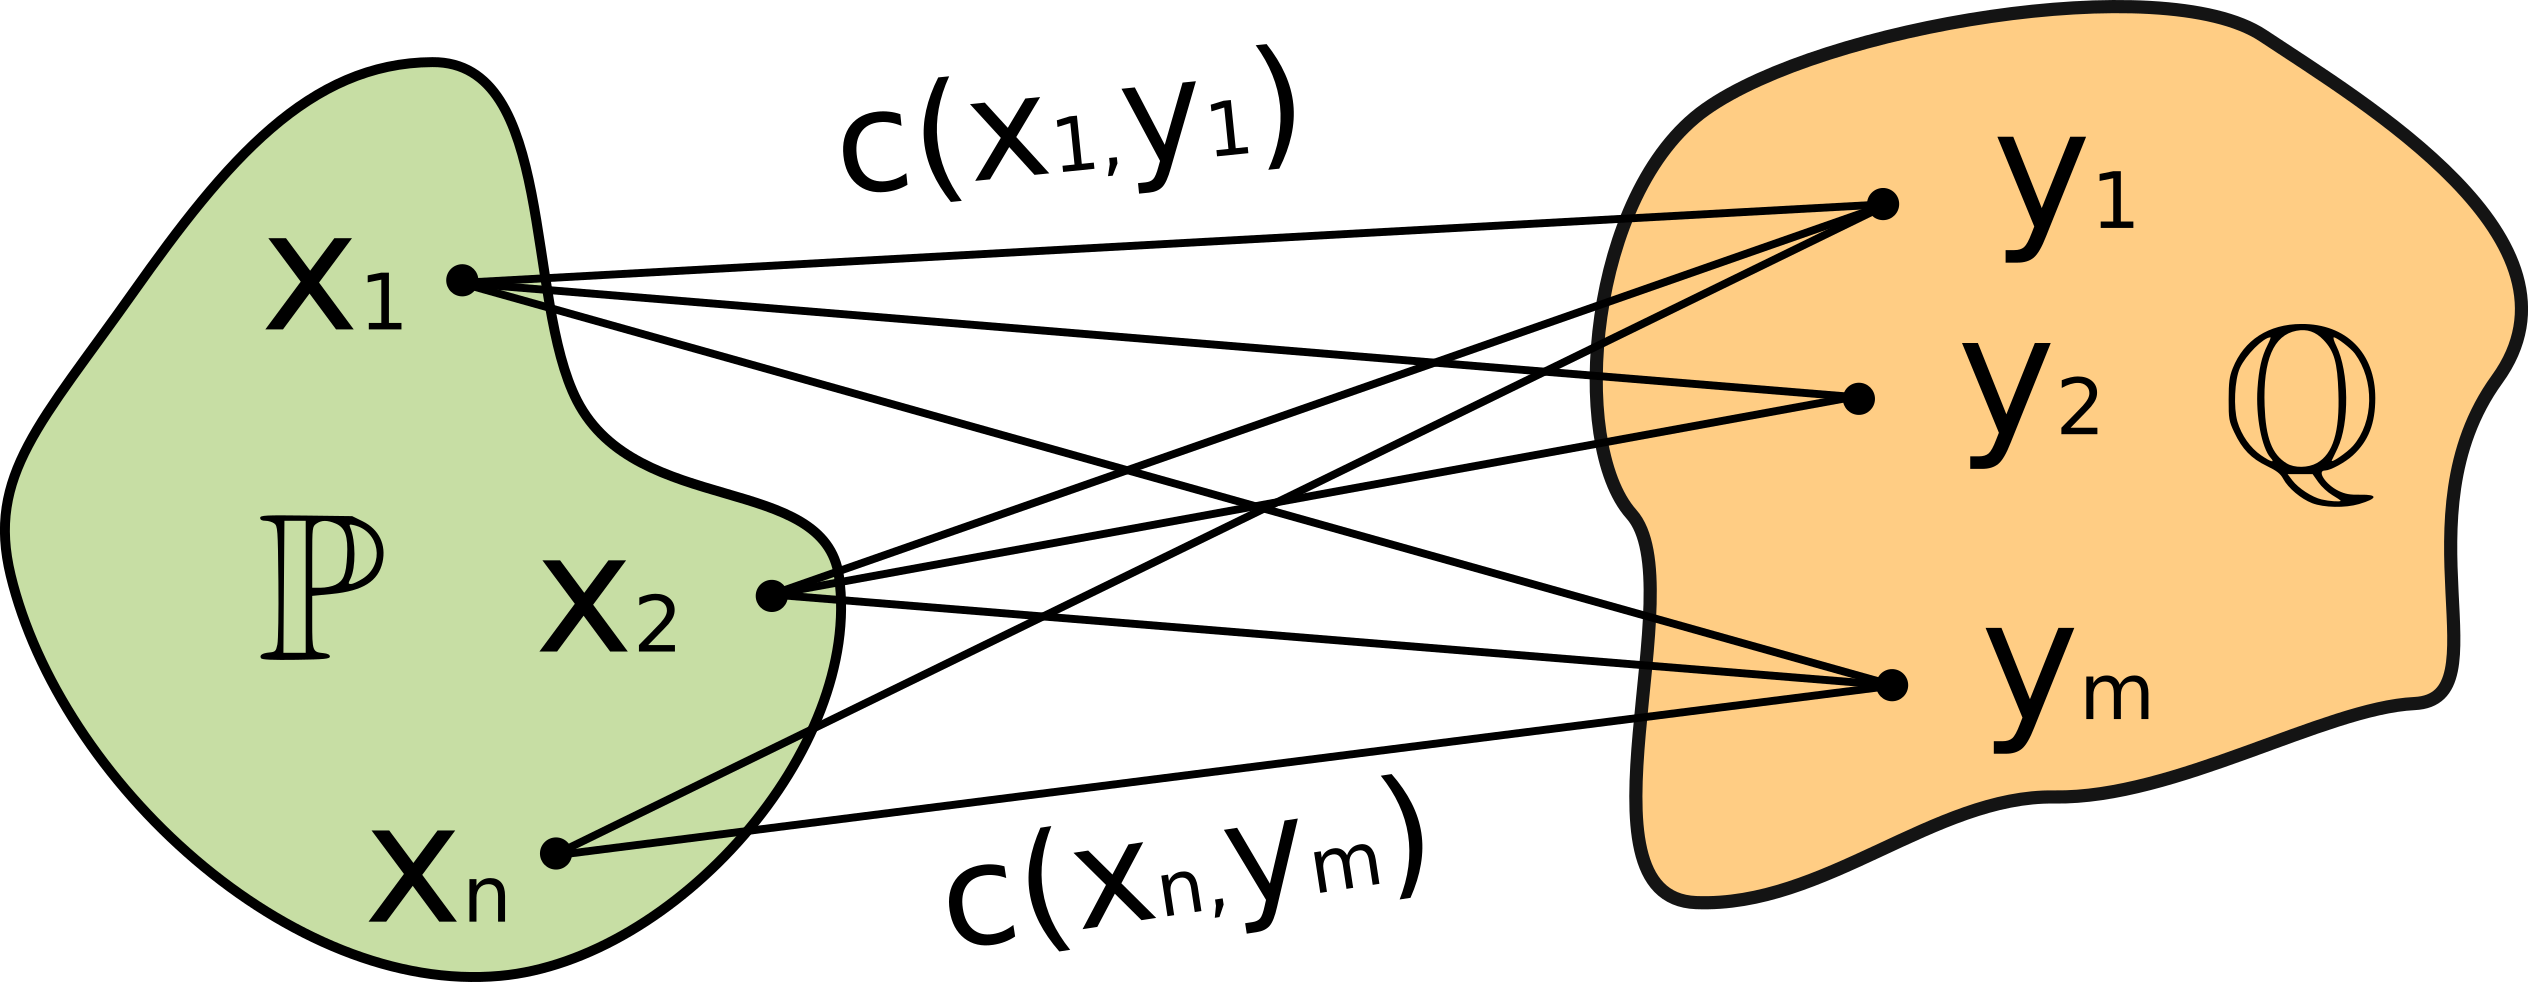">

**Weak OT formulation.** For a weak cost function $C:\mathcal{X}\times\mathcal{P}(\mathcal{Y})\rightarrow \mathbb{R}$, the weak formulation of OT is
$$\text{Cost}(\mathbb{P},\mathbb{Q})=\inf_{{\color{blue}\pi}\in\Pi(\mathbb{P},\mathbb{Q})}\int_{\mathcal{X}}C\big(x,{\color{blue}\pi(\cdot|x)}\big)\underbrace{d{\color{blue}\pi_{x}}(x)}_{=d\mathbb{P}(x)}.$$
Here ${\color{blue}\pi}_{x}(x)$ denotes the marginal distribution over $x\in\mathcal{X}$ and ${\color{blue}\pi}(\cdot |x)$ denotes the distribution of $y\in\mathcal{Y}$ conditioned on $x\in\mathcal{X}$.

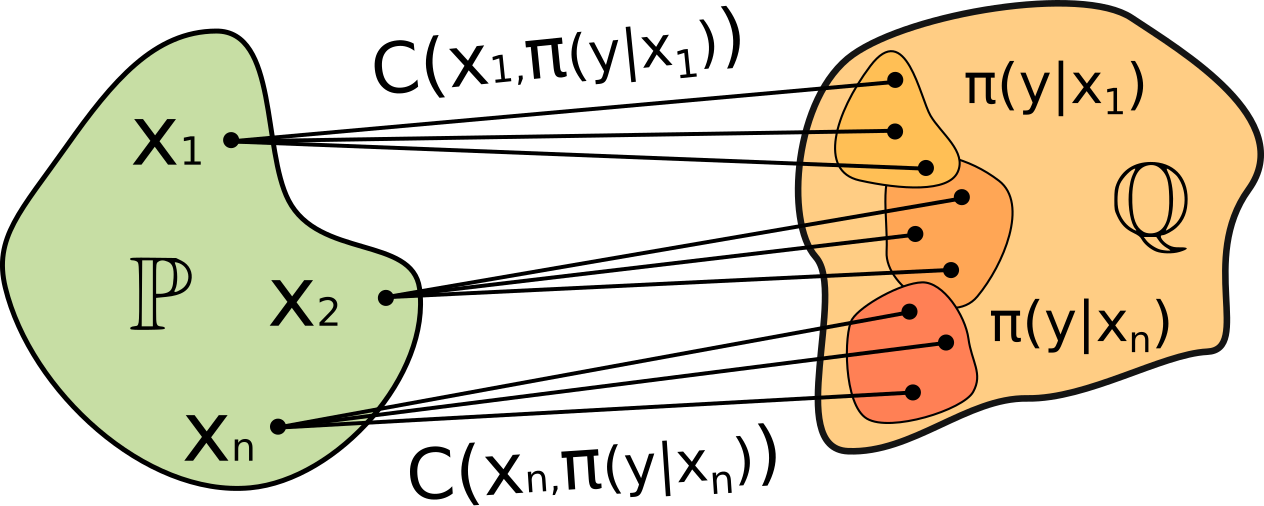

❔ Think why the weak OT generalizes the strong OT. Which $C(x,{\color{blue}\pi}(\cdot|x))$ one should use to get the strong OT with cost $c(x,y)$ from the weak OT?
$$C(x,{\color{blue}\pi}(\cdot|x))=\text{<<Your answer here>>}.$$

**Weak cost functions.** Most of the theory works in rather general spaces $\mathcal{X},\mathcal{Y}$, but in practice we will focus on $\mathcal{X}=\mathcal{Y}=\mathbb{R}^{D}$. In this case, two most popular examples of a weak cost function $C$ are

* The $\gamma$-**weak quadratic cost** ($\gamma\geq 0$):
$$C_{2,\gamma}\big(x,{\color{blue}\pi}(\cdot |x)\big)\stackrel{def}{=}\underbrace{\int_{\mathcal{Y}}\frac{1}{2}\|x-y\|^{2}_{2}d{\color{blue}\pi}(y|x)}_{\text{Strong cost}}-\frac{\gamma}{2}\underbrace{\text{Var}\big({\color{blue}\pi}(\cdot |x)\big)}_{\text{Variance}}.$$
* The $\epsilon$-**entropic (quadratic) cost** ($\gamma\geq 0$):
$$C_{2,\epsilon}\big(x,{\color{blue}\pi}(\cdot |x)\big)\stackrel{def}{=}\underbrace{\int_{\mathcal{Y}}\frac{1}{2}\|x-y\|^{2}_{2}d{\color{blue}\pi}(y|x)}_{\text{Strong cost}}-\epsilon\underbrace{\text{Ent}\big({\color{blue}\pi}(\cdot |x)\big)}_{\text{Entropy}}.$$

In both cases, the 1st term (*strong* part) stimulates the plan ${\color{blue}\pi}$ to produce $y\sim {\color{blue}\pi}(\cdot |x)$ which are close to $x$ in $\ell^{2}$ sense; the 2nd term (*weak* part) enforces the diversity for $y\sim {\color{blue}\pi}(\cdot |x)$.

The **dual OT form** which is needed for the NOT algorithm is given by
$$\text{Cost}(\mathbb{P},\mathbb{Q})=\sup_{{\color{red}f}}\inf_{{\color{blue}\pi}\in\Pi(\mathbb{P})}\underbrace{\big[\int_{\mathcal{X}}C\big(x,{\color{blue}\pi}(\cdot|x)\big)\overbrace{d\mathbb{P}(x)}^{=d{\color{blue}\pi}_x(x)}-\int_{\mathcal{X}}\big(\int_{\mathcal{Y}}{\color{red}f}(y)d{\color{blue}\pi}(y|x)\big)\overbrace{d\mathbb{P}(x)}^{=d{\color{blue}\pi}_x(x)}+\int_{\mathcal{Y}}{\color{red}f}(y)d\mathbb{Q}(y)\big]}_{\stackrel{def}{=}\mathcal{L}({\color{red}f},{\color{blue}\pi})},$$
where the $\sup_{\color{red}f}$ is taken over functions ${\color{red}f}:\mathcal{Y}\rightarrow \mathbb{R}$ (potentials). In turn, $\Pi(\mathbb{P})$ denotes the set of probability distributions ${\color{blue}\pi}\in\mathcal{P}(\mathcal{X}\times\mathcal{Y})$ whose projection onto $\mathcal{X}$ is $\mathbb{P}$. One may think about each ${\color{blue}\pi}\in\Pi(\mathbb{P})$ as of a family of conditional distributions $\{{\color{blue}\pi}(\cdot|x)\}_{x\in\mathcal{X}}$ which is "stick" to ${\color{blue}\pi}_{x}=\mathbb{P}\in\mathcal{P}(\mathcal{X})$. Namely, ${\color{blue}\pi}(\cdot|x)\in\mathcal{P}(\mathcal{Y})$ shows how to redistribute the mass of a point $x\sim\mathbb{P}$ among points $y\in\mathcal{Y}$. In this seminar, we will derive this dual form and implement the NOT algorithm which optimizes it with neural nets and recovers a saddle point $({\color{red}f^{*}},{\color{blue}\pi^{*}})$.

🔎 **Remark.** This duality formula holds true for *convex* (in the second argument) weak costs $C(\cdot,\cdot)$, see [this paper](https://arxiv.org/abs/1809.05893). We will explicitly use the convexity in the derivations below. There are some additional requirements, e.g., $C(\cdot,\cdot)$ should be lower-semicontinuous and lower-bounded. For simplicity of the exposition, we will not focus on these math details too much.

## 1. Theoretical part. Derivation of the duality for weak costs and the NOT algorithm
Here we derive a rather short ideological proof of the alternative duality formula needed for NOT. The provided proof is insiped by the awesome [book](http://math.univ-lyon1.fr/~santambrogio/OTAM-cvgmt.pdf) by Santambrogio (see Section 1.2). As the goal of this section is to give the general intuition (we will not be very mathematically rigorous).

We consider the weak formulation of OT. It is an optimization problem with the constraint ${\color{blue}\pi}\in\Pi(\mathbb{P},\mathbb{Q}$). We derive its dual form (*steps 1-3*) and then establish a practical neural algorithm to solve it (*step 4*).

**Step 1 [Indicator function].** For two distrubtions $\mathbb{Q}_{1},\mathbb{Q}_{2}$ on $\mathcal{Y}$ we note that
$$I_{\mathbb{Q}_1,\mathbb{Q}_2}\stackrel{def}{=}\sup_{{\color{red}f}}\big[\int_{\mathcal{Y}}{\color{red}f}(y)d\mathbb{Q}_{2}(y)-\int_{\mathcal{Y}}{\color{red}f}(y)d\mathbb{Q}_{1}(y)\big]=\begin{cases}
			0, & \text{if }\mathbb{Q}_1=\mathbb{Q}_2\\
            +\infty, & \text{otherwise}
		 \end{cases}.$$

**Step 2 [Removing the right constraint].** We incorporate the *right* constraint ${\color{blue}\pi}_{y}=\mathbb{Q}$ into the weak OT problem via adding $I_{{\color{blue}\pi}_{y},\mathbb{Q}}$:
$$\text{Cost}(\mathbb{P},\mathbb{Q})=\inf_{{\color{blue}\pi}\in\Pi(\mathbb{P},\mathbb{Q})}\int_{\mathcal{X}}C\big(x,{\color{blue}\pi(\cdot|x)}\big)d\mathbb{P}(x)=\inf_{{\color{blue}\pi}\in\Pi(\mathbb{P})}\big[\int_{\mathcal{X}}C\big(x,{\color{blue}\pi(\cdot|x)}\big)d\mathbb{P}(x)+I_{{\color{blue}\pi}_{y},\mathbb{Q}}\big].$$
The problems are indeed equivalent: if in the right problem ${\color{blue}\pi}_{y}\neq \mathbb{Q}$, then the expession inside $\inf_{{\color{blue}\pi}\in\Pi(\mathbb{P})}$ equals $+\infty$.

**Step 3 [Swapping inf and sup].** If we expand $I_{{\color{blue}\pi}_{y},\mathbb{Q}}$ in step 2 and [disintegrate](https://en.wikipedia.org/wiki/Disintegration_theorem) $d{\color{blue}\pi}_{y}(y)=\int_{\mathcal{X}}d{\color{blue}\pi}(y|x)d{\color{blue}\pi}_{x}(x)$, we obtain
$$\text{Cost}(\mathbb{P},\mathbb{Q})=\inf_{{\color{blue}\pi}\in\Pi(\mathbb{P})}\sup_{{\color{red}f}}\big[\int_{\mathcal{X}}C\big(x,{\color{blue}\pi}(\cdot|x)\big)d\mathbb{P}(x)-\int_{\mathcal{Y}}{\color{red}f}(y)d{\color{blue}\pi}_{y}(y)+\int_{\mathcal{Y}}{\color{red}f}(y)d\mathbb{Q}(y)\big]=$$
$$\inf_{{\color{blue}\pi}\in\Pi(\mathbb{P})}\sup_{{\color{red}f}}\big[\int_{\mathcal{X}}C\big(x,{\color{blue}\pi}(\cdot|x)\big)d\mathbb{P}(x)-\int_{\mathcal{X}}\big(\int_{\mathcal{Y}}{\color{red}f}(y)d{\color{blue}\pi}(y|x)\big)d\mathbb{P}(x)+\int_{\mathcal{Y}}{\color{red}f}(y)d\mathbb{Q}(y)\big]$$
The last thing is to swap $\inf$ and $\sup$. For this, we need the [minimax theorem](https://doducthao.github.io/assets/dl_posts/gan/simons1995.pdf). To apply it, we have to check that
- $\mathcal{L}({\color{red}f},{\color{blue}\pi})$ is convex in ${\color{blue}\pi}\in\Pi(\mathbb{P})$; this follows from convexity of $C(\cdot,\cdot)$ in the second argument;
- $\mathcal{L}({\color{red}f},{\color{blue}\pi})$ is concave in ${\color{red}f}$; this holds true as our functional is *linear* in ${\color{red}f}$.

The minimax theorem also requires $\Pi(\mathbb{P})$ to be a compact set. In general, this is not true. However, assuming, e.g., that $\mathcal{X},\mathcal{Y}\subset \mathbb{R}^{D}$ are a compact subsets, one may obtain that $\Pi(\mathbb{P})$ is (weakly) compact, e.g., see the proof of Theorem 1.4 [here](http://math.univ-lyon1.fr/~santambrogio/OTAM-cvgmt.pdf). Therefore, the desired dual formula $\text{Cost}(\mathbb{P},\mathbb{Q})=\sup_{{\color{red}f}}\inf_{{\color{blue}\pi}\in\Pi(\mathbb{P})}\mathcal{L}({\color{red}f},{\color{blue}\pi})$ holds.
$\square$

❔ Recall the [previous seminar](https://github.com/iamalexkorotin/NeuralOptimalTransport/blob/main/seminars/NOT_seminar_strong.ipynb). There we derived the duality formula for strong OT. We slightly cheated when "applied" the minimax theorem since the functional $\mathcal{L}({\color{red}f},{\color{blue}T})$ considered there was **not** convex in ${\color{blue}T}$:
$$\text{Cost}(\mathbb{P},\mathbb{Q})=\sup_{{\color{red}f}}\inf_{{\color{blue}T}}\underbrace{\big[\int_{\mathcal{X}}c\big(x,{\color{blue}T}(x)\big)d\mathbb{P}(x)-\int_{\mathcal{X}}{\color{red}f}\big({\color{blue}T}(x)\big)d\mathbb{P}(x)+\int_{\mathcal{Y}}{\color{red}f}(y)d\mathbb{Q}(y)\big]}_{\stackrel{def}{=}\mathcal{L}({\color{red}f},{\color{blue}T})},$$
Now your task is to obtain this duality formula for strong OT *from the derived duality formula for weak OT*. You need to substitute $C\big(x,{\color{blue}\pi}(y|x)\big)=\int_{\mathcal{Y}}c(x,y)d{\color{blue}\pi}(y|x)$ and explain why optimization over plans ${\color{blue}\pi}$ can be reduced to the optimization over deterministic maps ${\color{blue}T}$.
$$\text{<<Your solution here>>}$$

**Step 4 [Establishing the NOT algorithm].** The weak OT problem is a constrained problem, ${\color{blue}\pi}\in\Pi(\mathbb{P},\mathbb{Q})$. In turn, the dual problem removes one of the constraints and the second constraint ${\color{blue}\pi}\in\Pi(\mathbb{P})$ can be easily satisfied by using the implicit reformulation of the problem (we will see this below) . The main feature of the maximin dual form is that one may recover an OT plan ${\color{blue}\pi^{*}}$ from *some* optimal points $({\color{red}f^{*}},{\color{blue}\pi^{*}})$ of $\mathcal{L}({\color{red}f},{\color{blue}\pi})$. Below we skip the theoretical questions about the existence of optimal saddle points and focus on how to compute them.

To begin with, we need to understand how to optimize over plans $\color{blue}{\pi}\in\Pi(\mathbb{P})$ or, equivalently, over a family of conditional distributions $\{{\color{blue}\pi}(\cdot|x)\}_{x\in\mathcal{X}}$. For this, we introduce a new space $\mathcal{Z}$ (a.k.a. *latent space*) and a simple distribution $\mathbb{S}\in\mathcal{P}(\mathcal{Z})$ on it. For example, $\mathcal{Z}=\mathbb{R}^{Z}$  and $\mathbb{S}=\mathcal{N}(0,I_{Z})$. Next, we replace the optimization over distributions $\{{\color{blue}\pi}(\cdot|x)\}_{x\in\mathcal{X}}$ with the *equivalent* optimization over functions ${\color{blue}T}_{x}:\mathcal{Z}\rightarrow\mathcal{Y}$ which *generate* these distributions, i.e., ${\color{blue}T}_{x}(z)\sim {\color{blue}\pi}(\cdot|x)$ when $z\sim\mathbb{S}$. We call such functions ${\color{blue}T}:\mathcal{X}\times\mathcal{Z}\rightarrow\mathcal{Y}$ *stochastic maps*.

<img width=320 src=" 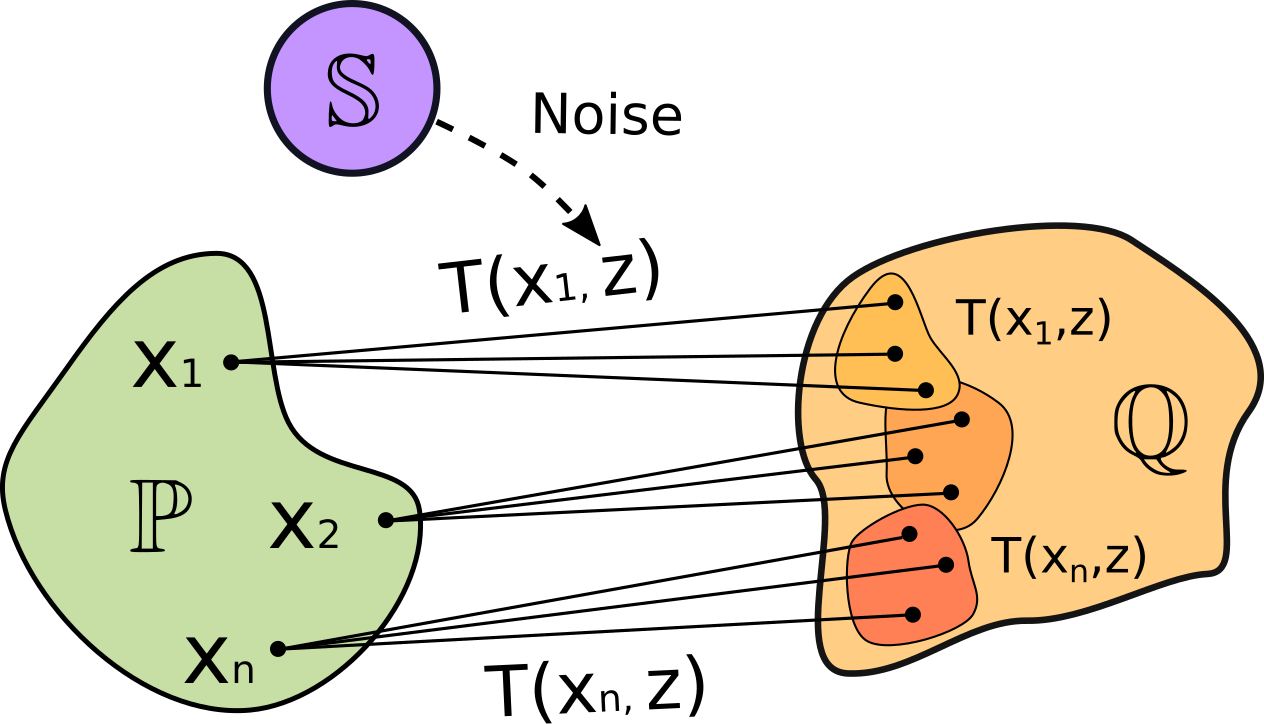">

After the change of variables in our duality formula with plan ${\color{blue}\pi}$, we obtain the duality formula with *stochastic* map ${\color{blue}T}$:
$$\text{Cost}(\mathbb{P},\mathbb{Q})=\sup_{{\color{red}f}}\inf_{{\color{blue}T}}\int_{\mathcal{X}}C\big(x,{\color{blue}T}_{x}\sharp\mathbb{S}\big)d\mathbb{P}(x)-\int_{\mathcal{X}}\int_{\mathcal{Z}}{\color{red}f}\big({\color{blue}T}_{x}(z)\big) d\mathbb{S}(z) d\mathbb{P}(x)+\int_{\mathcal{Y}}{\color{red}f}(y)d\mathbb{Q}(y).$$
The resulting formula can be easily approached with neural networks ${\color{blue}T}_{\theta}, {\color{red}f}_{\omega}$ as ${\color{blue}T}:\mathcal{X}\times\mathcal{Z}\rightarrow\mathcal{Y},{\color{red}f}:\mathcal{Y}\rightarrow\mathcal{R}$. To optimize their parameters $\theta,\omega$, one may use the stochastic gradient descent/ascent. The latter two terms can be estimated by using random batches from $\mathbb{P},\mathbb{Q},\mathbb{S}$.

❔ To stochastically estimate the  term $\int_{\mathcal{X}}C\big(x,{\color{blue}T}_{x}\sharp\mathbb{S}\big)d\mathbb{P}(x)$, one need to estimate $C(x,{\color{blue}T}_{x}\sharp\mathbb{S})$ on a random batch $z_{1},\dots,z_{K}\sim\mathbb{S}$.
- Consider the $\gamma$-weak quadratic cost $C_{2,\gamma}$. Provide the formula for its *unbiased* estimator:
$$C_{2,\gamma}(x,{\color{blue}T}_{x}\sharp\mathbb{S})\approx \widehat{C}_{2,\gamma}\big(x,\{{\color{blue}T}_{x}(z_{k})\}_{k=1}^{K}\big)=\text{<<Your solution here>>}.$$
- Consider the $\epsilon$-entropic quadratic cost $C_{2,\epsilon}$. Provide the formula for its *unbiased* estimator:
$$C_{2,\epsilon}(x,{\color{blue}T}_{x}\sharp\mathbb{S})\approx \widehat{C}_{2,\epsilon}\big(x,\{{\color{blue}T}_{x}(z_{k})\}_{k=1}^{K}\big)=\text{<<Your solution here>>}.$$
Why it is non-trivial to provide a stochastic estimator for the entropic case? How to overcome the issue in practice?

Now we are ready to implement NOT algorithm in practice.

## 2. Practical part. Learning optimal stochastic maps with neural nets

In [3]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
%matplotlib inline

import random
import numpy as np

import torch
import torch.nn as nn

import torchvision.datasets as datasets
from torchvision import transforms

from IPython.display import clear_output
from tqdm.notebook import tqdm as tqdm

from sklearn.datasets import make_swiss_roll

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

### 2.1. Toy 2D example (fully connected neural networks)
We are going train a neural net to optimally map the 2D standard Gaussian to a Swiss Roll. Let us take a look at this pair of distributions.

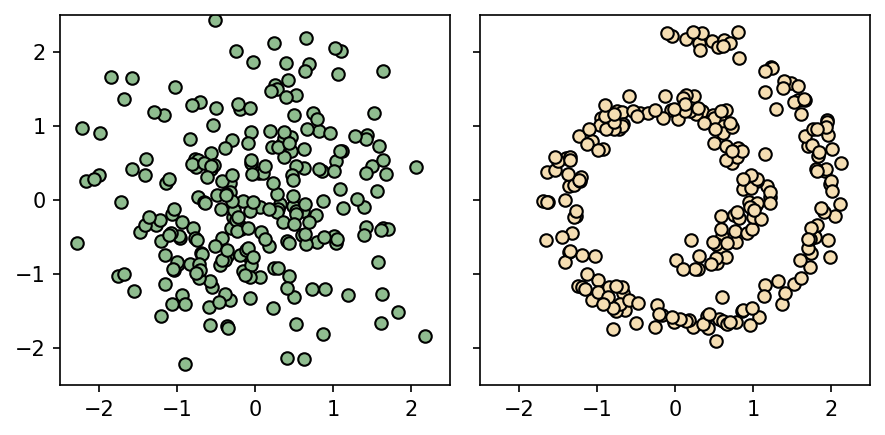

In [224]:
# Use these functions to sample from the distributions

def sample_normal(size=64):
    return np.random.normal(size=(size,2)).astype(np.float32)

def sample_swiss(size=64):
    return make_swiss_roll(
        n_samples=size, noise=0.8
    )[0].astype('float32')[:, [0, 2]] / 6.5

X = sample_normal(256)
Y = sample_swiss(256)

fig, axes = plt.subplots(1, 2, figsize=(6,3), dpi=150, sharex=True, sharey=True)
axes[0].scatter(X[:,0], X[:, 1], c='darkseagreen', edgecolors='black')
axes[1].scatter(Y[:,0], Y[:, 1], c='wheat', edgecolors='black')
axes[0].set_xlim(-2.5, 2.5); axes[1].set_ylim(-2.5, 2.5)
fig.tight_layout()

To begin with, we will work with the **$\gamma$-weak quadratic cost** $C_{2,\gamma}$. Write a code to estimate it on a random batch.


In [225]:
def weak_sq_cost(X, T_XZ, gamma):
    """
    Input
    --------
    X : tensor, shape (bs, dim) or (bs, n_ch, w, h)
    T_XZ : tensor, shape (bs, z_size, dim) or (bs, z_size, n_ch, w, h)
    gamma : float

    Output
    --------
    cost : tensor, shape ()
    """
    X = X.flatten(start_dim=1)
    T_XZ = T_XZ.flatten(start_dim=2)
    z_size = T_XZ.size(1)
    
    l2 = # <<< your code here >>>
    var = # <<< your code here >>>
    return l2 - 0.5 * gamma * var

COST = weak_sq_cost

Now define the networks for the stochastic transport map ${\color{blue}T}:\mathcal{X}\times\mathcal{Z}\rightarrow \mathcal{Y}$ and potential ${\color{red}f}:\mathcal{Y}\rightarrow \mathbb{R}$. We work in 2D, i.e., $\mathcal{X}=\mathcal{Y}=\mathbb{R}^{2}$. For convenience, let us also use $\mathcal{Z}=\mathbb{R}^{2}$. The transport map ${\color{blue}T}$ should take two inputs: sample $x\in\mathbb{R}^{2}$ and noise $z\in\mathbb{R}^{2}$. For simplicity, we simply concatenate these things and consider a single $2+2=4$ dimensional input $(x,z)$ to ${\color{blue}T}$, i.e., we need to define ${\color{blue}T}:\mathbb{R}^{2+2}\rightarrow \mathbb{R}^{2}$ (generator) and potential ${\color{red}f}:\mathbb{R}^{2}\rightarrow \mathbb{R}$ (discriminator). It sufficies to use medium-size multi-layer perceptrons for ${\color{blue}T},{\color{red}f}$ with ReLU activations.

In [226]:
T = nn.Sequential(
    # <<< your code here >>>
).to(DEVICE)

f = nn.Sequential(
    # <<< your code here >>>
).to(DEVICE)

print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
print('f params:', np.sum([np.prod(p.shape) for p in f.parameters()]))

T params: 33922
f params: 33537


Define the optimizers for ${\color{blue}T}, {\color{red}f}$ (Adam is recommended):

In [227]:
T_opt = # <<< your code here >>>
f_opt = # <<< your code here >>>

Now implement NOT algorithm for strong costs (Algorithm 1 in [NOT paper](https://openreview.net/pdf?id=d8CBRlWNkqH)) and train the networks:

<img width=600 src=" 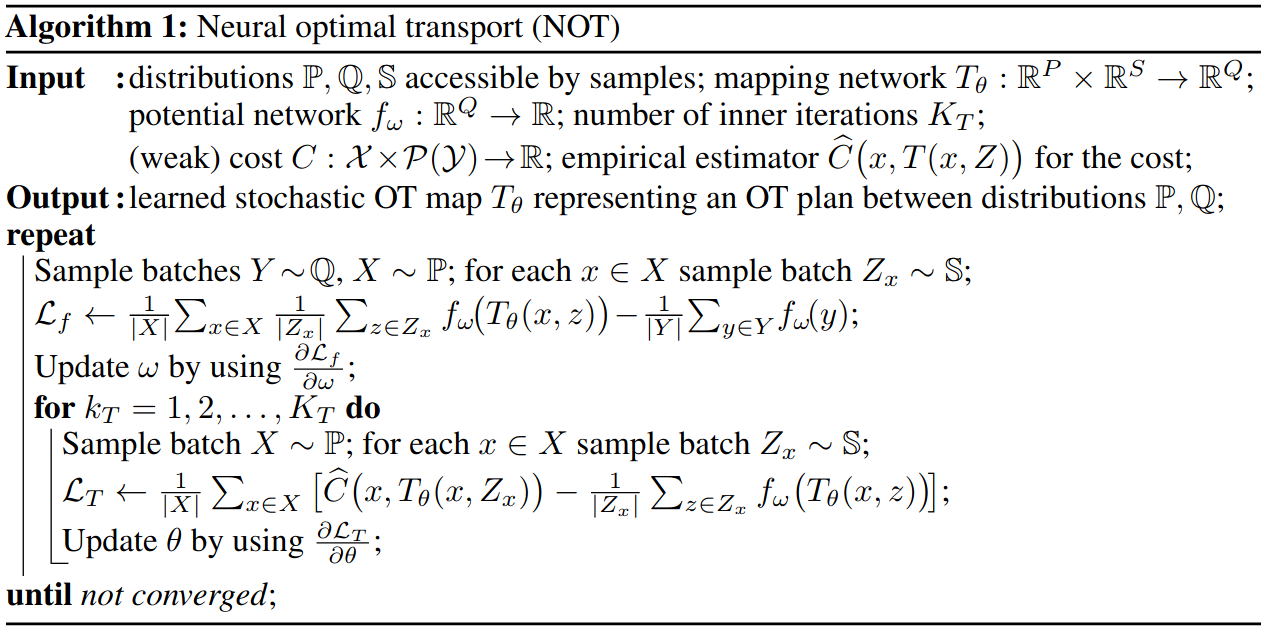">

In [228]:
# Parameters
T_ITERS = 10 # how much T updates to do per 1 update of
BATCH_SIZE = 64 # how much x~P to sample per batch
Z_SIZE = 4 # how much z's to sample per each x
MAX_STEPS = 4000 # total number of training steps
GAMMA = 1. # variance parameter, >=0

# Fixed samples for plotting (we use the standard normal as noise vectors z)
X_fixed, Y_fixed = sample_normal(256), sample_swiss(256)
Z_fixed = np.random.normal(size=(256, Z_SIZE, 2))
XZ_fixed = np.concatenate((X_fixed[:,None].repeat(Z_SIZE,1), Z_fixed), axis=2).astype(np.float32)

Step 3800
gamma=1.0


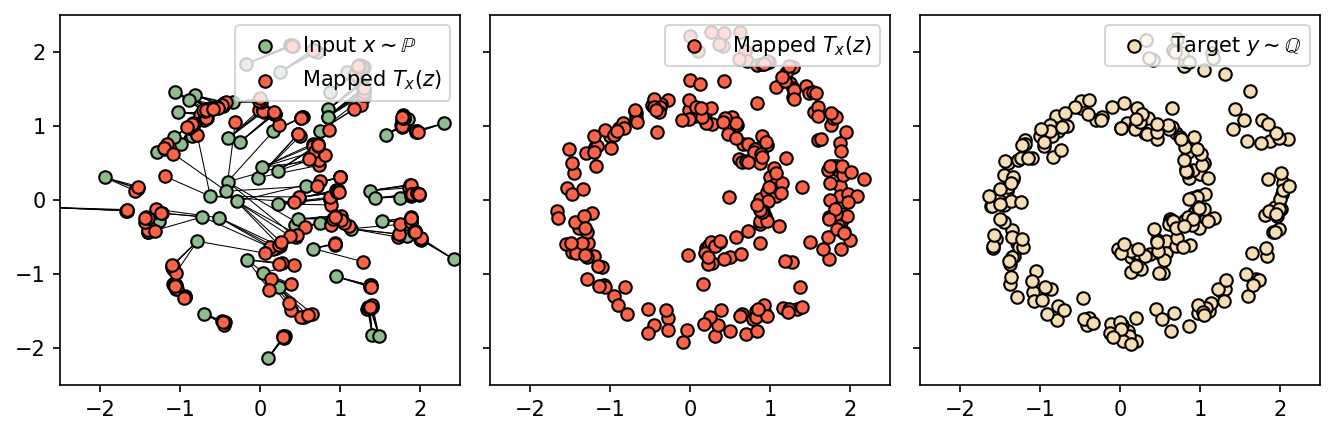

In [231]:
# NOT algorithm
for step in tqdm(range(MAX_STEPS)):
    # T optimization
    T.train(True); f.eval()
    for t_iter in range(T_ITERS):
        # Sample X, Z
        X = torch.tensor(sample_normal(BATCH_SIZE), device=DEVICE) # (bs, dim)
        Z = torch.randn(BATCH_SIZE, Z_SIZE, 2, device=DEVICE) # (bs, z_size, z_dim)

        # Get T_XZ
        XZ = torch.cat([X[:,None].repeat(1, Z_SIZE,1), Z], dim=2)  # (bs, z_size, dim+z_dim)
        T_XZ = # <<< your code here >>> # (bs, z_size, dim)

        # Compute the loss for T
        T_loss = # <<< your code here >>>
        T_opt.zero_grad(); T_loss.backward(); T_opt.step()

    # f optimization
    T.eval(); f.train(True)
    # Sample X, Y, Z
    X = torch.tensor(sample_normal(BATCH_SIZE), device=DEVICE) # (bs, dim)
    Y = torch.tensor(sample_swiss(BATCH_SIZE), device=DEVICE) # (bs, dim)
    Z = torch.randn(X.size(0), Z_SIZE, 2, device=DEVICE) # (bs, z_size, dim)

    # Get T_XZ
    XZ = torch.cat([X[:,None].repeat(1, Z_SIZE,1), Z], dim=2)  # (bs, z_size, dim+z_dim)
    T_XZ = # <<< your code here >>> # (bs, z_size, dim)

    # Compute the loss for f
    f_loss = # <<< your code here >>>
    f_opt.zero_grad(); f_loss.backward(); f_opt.step()

    if step % 200 == 0:
        clear_output(wait=True)
        print("Step", step)

        # The code for plotting the results
        print('gamma={}'.format(GAMMA))
        fig, axes = plt.subplots(1, 3, figsize=(9,3), dpi=150, sharex=True, sharey=True)
        XZ_fixed = torch.tensor(XZ_fixed, device=DEVICE)
        with torch.no_grad():
            T_XZ_fixed = T(
                XZ_fixed.flatten(start_dim=0, end_dim=1)
            ).permute(1,0).reshape(-1,256,Z_SIZE).permute(1,2,0).to('cpu').numpy()
            XZ_fixed = XZ_fixed.to('cpu').numpy()
        lines =  list(zip(XZ_fixed[:64,:,:2].reshape(-1,2), T_XZ_fixed[:64].reshape(-1,2)))
        axes[0].set_xlim(-2.5, 2.5); axes[0].set_ylim(-2.5, 2.5)

        lc = mc.LineCollection(lines, linewidths=0.5, color='black')
        axes[0].add_collection(lc)
        axes[0].scatter(X_fixed[:64,0], X_fixed[:64, 1], c='darkseagreen', edgecolors='black', zorder=2, label=r'Input $x\sim\mathbb{P}$')
        axes[0].scatter(T_XZ_fixed[:64].reshape(64*Z_SIZE,-1)[:,0], T_XZ_fixed[:64].reshape(64*Z_SIZE,-1)[:,1], c='tomato', edgecolors='black', zorder=3, label=r'Mapped $T_x(z)$')
        axes[1].scatter(T_XZ_fixed[:,0,0], T_XZ_fixed[:,0,1], c='tomato', edgecolors='black', label=r'Mapped $T_x(z)$')
        axes[2].scatter(Y_fixed[:,0], Y_fixed[:, 1], c='wheat', edgecolors='black', label=r'Target $y\sim\mathbb{Q}$')
        axes[0].legend(loc='upper right'); axes[1].legend(loc='upper right'); axes[2].legend(loc='upper right')
        fig.tight_layout(); plt.show()

Understanding whether the learned stochastic map is indeed optimal is not trivial. Comparison with the **ground truth** is not possible due to 
- 🤦 **Unknown ground truth (GT).** Indeed, even for the strong OT it is hard to get the GT. It is known for a limited number of distribution pairs, e.g., Gaussians plus some manually constructed *benchmark pairs*, see the [Wasserstein-2 benchmark](https://github.com/iamalexkorotin/Wasserstein2Benchmark). For the weak OT, the ground truth is even harder to obtain. In small dimensions, e.g., 2D, one may consider a [discrete weak OT](https://pythonot.github.io/gen_modules/ot.weak.html) as a fine approximation of the ground truth. This is done in [NOT](https://openreview.net/pdf?id=d8CBRlWNkqH) and [KNOT](https://openreview.net/pdf?id=Zuc_MHtUma4) papers and their toy experiments ([1D](https://github.com/iamalexkorotin/NeuralOptimalTransport/blob/main/notebooks/NOT_toy_1D.ipynb), [2D](https://github.com/iamalexkorotin/NeuralOptimalTransport/blob/main/notebooks/NOT_toy_2D.ipynb), [1D](https://github.com/iamalexkorotin/KernelNeuralOptimalTransport/blob/main/notebooks/KNOT_toy_1D.ipynb), [2D](https://github.com/iamalexkorotin/KernelNeuralOptimalTransport/blob/main/notebooks/KNOT_toy_2D.ipynb)). Yet this approach is not applicable in higher dimensions.
- 🤦 **Non-uniqueness of the optimal plan.** For the $\gamma$-weak quadratic cost $C_{2,\gamma}$, the OT plan may be non-unique, see discussion in Appendices B, C in [NOT paper](https://openreview.net/pdf?id=d8CBRlWNkqH). Fortunately, when the weak cost is strictly convex, e.g., entropic $C_{2,\epsilon}$ or kernel $C_{1,\gamma}$ (will be introduced later), the OT plan is unique.

❔ Anyway, in this seminar we are going to only **indirectly** check that the method works. As the cost $C_{2,\gamma}$ is the difference of strong $\ell^{2}$ and $\gamma$ multiplied by variance, for small $\gamma\approx 0$ we expect the method to behave similar to strong $\ell^{2}$ which we tested in the [previous seminar](https://github.com/iamalexkorotin/NeuralOptimalTransport/blob/main/seminars/NOT_seminar_strong.ipynb). With the increase of $\gamma$ we expect the increase in the variance of the samples generated from each input $x\sim\mathbb{P}$.
- 👍 Test $\gamma=0$ and think whether the method behaves analogously to strong $\ell^{2}$;
- 👍 Test $\gamma=0, 0.1, 0.5, 1.$ and see that the conditional variance of samples increases;
- 👎 Test $\gamma=10$ and see that the method diverges.

One of the reasons why the method diverges for large $\gamma$ are the **fake solutions** which are studied and resolved in the [KNOT paper](https://openreview.net/pdf?id=Zuc_MHtUma4). This is also connected to the **non-strict** convexity of the cost $C_{2,\gamma}$. We are not going to discuss the issue with fake solutions in this seminar. Additionally, see Appendix F in [NOT paper](https://openreview.net/pdf?id=d8CBRlWNkqH). If you want to dig deeper, consider the [Kernel NOT](https://arxiv.org/abs/2205.15269) paper which studies fake solutions.

Now code and test the following **$\gamma$-weak kernel cost**:
$$C_{1,\gamma}\big(x,{\color{blue}\pi}(\cdot |x)\big)\stackrel{def}{=}\underbrace{\int_{\mathcal{Y}}\frac{1}{2}\|x-y\|_{2}d{\color{blue}\pi}(y|x)}_{\text{Strong cost}}-\frac{\gamma}{2}\underbrace{\int_{\mathcal{Y}}\int_{\mathcal{Y}}\frac{1}{2}\|y-y'\|_{2}{\color{blue}\pi}(y' |x)d{\color{blue}\pi}(y |x)}_{\text{Kernel variance}}.$$
🔎 **Remark.** In both terms, there is $\ell^2$ norm in the first power, not $\ell^{1}$.

In [12]:
def weak_kernel_cost(X, T_XZ, gamma):
    """
    Input
    --------
    X : tensor, shape (bs, dim) or (bs, n_ch, w, h)
    T_XZ : tensor, shape (bs, z_size, dim) or (bs, z_size, n_ch, w, h)
    gamma : float

    Output
    --------
    cost : tensor, shape ()
    """
    X = X.flatten(start_dim=1)
    T_XZ = T_XZ.flatten(start_dim=2)
    z_size = T_XZ.size(1)
    
    l2_dist = # <<< your code here >>>
    kvar = # <<< your code here >>>
    return l2_dist - 0.5 * gamma * kvar

COST = weak_kernel_cost

Please consult to the [Kernel NOT](https://arxiv.org/abs/2205.15269) for details about the cost. It is strictly convex and is expected to work better (for $\gamma>0$).
- 👎 Test $\gamma=0$ and see that $C_{1,0}$ is *not* a good (strong) cost, i.e., it will yields a "thin" swiss roll (think why!);
- 👍 Test $\gamma=0.1, 1, 10$ and see that $C_{1,\gamma}$ works well.

🔎 **Remark.** In practice, using high $\gamma$ may be unnecessary as this would yield a high conditional diversity of generated samples. When $\gamma\rightarrow \infty$, the method will generate the entire distribution $\mathbb{Q}$ from any input point $x\sim \mathbb{P}$, i.e., the model will become nearly *unconditional*.

### 2.2. One-to-many unpaired image-to-image translation (convolutional neural networks)
We are going to apply the NOT algorithm to learn the OT map for an unpaired image-to-image translation problem. We have access (via the empirical samples - datasets) to a pair of image distributions $\mathbb{P},\mathbb{Q}$. We aim to find a (one-sided) *image-to-image translation* map ${\color{blue}T}:\mathcal{X}\rightarrow\mathcal{Y}$ which transforms samples from the distribution $\mathbb{P}$ to $\mathbb{Q}$.

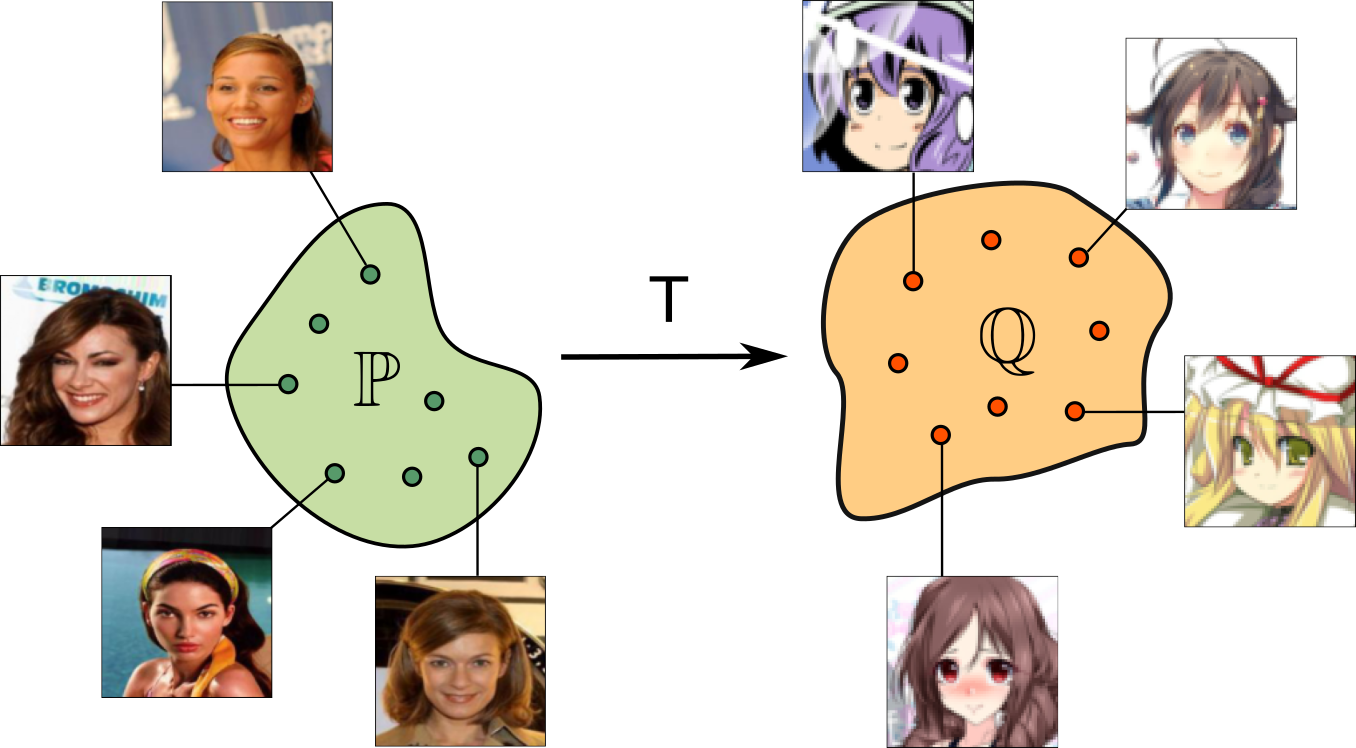

In many such problems, it is reasonable to use a stochastic OT map as the translation map as it aims to maximally preserve the input content (thanks to strong $\ell^{2}$) term and may yield controllable amount of diversity (thanks to the variance term). For an extended discussion, see Section 5.3 in [NOT paper](https://arxiv.org/abs/2201.12220). To keep the seminar simple, we consider $16\times 16$ colorized **MNIST** digits 2 and 3 and learn a stochastic OT map between them.

In [205]:
BATCH_SIZE = 16

def random_color(im):
    hue = 360*np.random.rand()
    d = (im *(hue%60)/60)
    im_min, im_inc, im_dec = torch.zeros_like(im), d, im - d
    c_im = torch.zeros((3, im.shape[1], im.shape[2]))
    H = round(hue/60) % 6    
    cmap = [[0, 3, 2], [2, 0, 3], [1, 0, 3], [1, 2, 0], [3, 1, 0], [0, 1, 2]]
    return torch.cat((im, im_min, im_dec, im_inc), dim=0)[cmap[H]]

TRANSFORM = transforms.Compose([
    transforms.Resize(16),
    transforms.ToTensor(),
    random_color,
    transforms.Normalize([0.5],[0.5])
])

# Load train datasets
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=TRANSFORM)
idx = np.array(range(len(mnist_train)))
mnist_2 = torch.utils.data.Subset(mnist_train, idx[mnist_train.targets==2])
mnist_3 = torch.utils.data.Subset(mnist_train, idx[mnist_train.targets==3])
mnist_2_loader = torch.utils.data.DataLoader(mnist_2, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
mnist_3_loader = torch.utils.data.DataLoader(mnist_3, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# Load test datasets
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=TRANSFORM)
idx = np.array(range(len(mnist_test)))
mnist_2_test = torch.utils.data.Subset(mnist_test, idx[mnist_test.targets==2])
mnist_3_test = torch.utils.data.Subset(mnist_test, idx[mnist_test.targets==3])
mnist_2_test_loader = torch.utils.data.DataLoader(mnist_2_test, batch_size=BATCH_SIZE)
mnist_3_test_loader = torch.utils.data.DataLoader(mnist_3_test, batch_size=BATCH_SIZE)

# We pick a few samples from them for the qualitative analysis
X_test_fixed = next(iter(mnist_2_test_loader))[0]
Y_test_fixed = next(iter(mnist_3_test_loader))[0]
Z_test_fixed = torch.randn(BATCH_SIZE, 4, 1, 16, 16)
with torch.no_grad():
    XZ_test_fixed = torch.cat([X_test_fixed[:,None].repeat(1,4,1,1,1), Z_test_fixed], dim=2)
del Z_test_fixed

del mnist_2_test_loader, mnist_3_test_loader, mnist_2_test, mnist_3_test, mnist_test

The code below can be used to sample batches from the datasets.

In [214]:
iter_mnist_2, iter_mnist_3 = iter(mnist_2_loader), iter(mnist_3_loader)

def sample_mnist_2():
    global iter_mnist_2, mnist_2_loader
    try:
        return next(iter_mnist_2)[0]
    except StopIteration:
        iter_mnist_2 = iter(mnist_2_loader)
        return next(iter_mnist_2)[0]

def sample_mnist_3():
    global iter_mnist_3, mnist_3_loader
    try:
        return next(iter_mnist_3)[0]
    except StopIteration:
        iter_mnist_3 = iter(mnist_3_loader)
        return next(iter_mnist_3)[0]

Let us take a look at the images from the datasets.

Random (unpaired) images from Colored MNIST-2 (1st row) and Colored MNIST-3 (2nd row) train sets


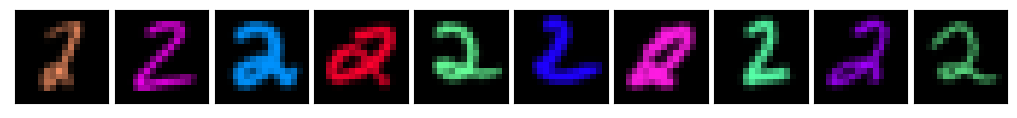

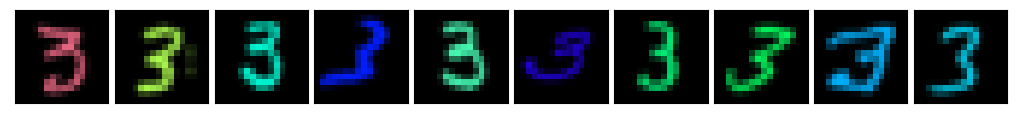

In [232]:
def plot_images(batch):
    fig, axes = plt.subplots(1, 10, figsize=(10, 1), dpi=100)
    for i in range(10):
        axes[i].imshow(batch[i].mul(0.5).add(0.5).clip(0,1).permute(1,2,0))
        axes[i].set_xticks([]); axes[i].set_yticks([])
    fig.tight_layout(pad=0.1)

print('Random (unpaired) images from Colored MNIST-2 (1st row) and Colored MNIST-3 (2nd row) train sets')
plot_images(sample_mnist_2())
plot_images(sample_mnist_3())

As in the toy 2D case, define the networks for transport map $\color{blue}T$ and $\color{red}f$. As the input noise $z$ for $\color{blue}T$, we are going to use $16\times 16$ tensor containing random Gaussian samples. That is, we have to construct a stochastic map ${\color{blue}T}:\mathbb{R}^{(3+1)\times 16\times 16} \rightarrow \mathbb{R}^{1\times 16\times 16}$ and potential ${\color{red}f}:\mathbb{R}^{3\times 16\times 16}\rightarrow \mathbb{R}$. It sufficies to use sequential convolutional networks with LeakyReLU non-linearities, MaxPool/AvgPool. Do not forget to define the optimizers for them.

In [216]:
T = nn.Sequential(
    # <<< your code here >>>
).to(DEVICE)

f = nn.Sequential(
    # <<< your code here >>>
).to(DEVICE)

T_opt = # <<< your code here >>>
f_opt = # <<< your code here >>>

print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
print('f params:', np.sum([np.prod(p.shape) for p in f.parameters()]))

T params: 2071171
f params: 6466817


Let us define and test the plot function.

<ipython-input-217-a45b3faf4ec9>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(XZ_test_fixed, device=DEVICE).flatten(start_dim=0, end_dim=1)


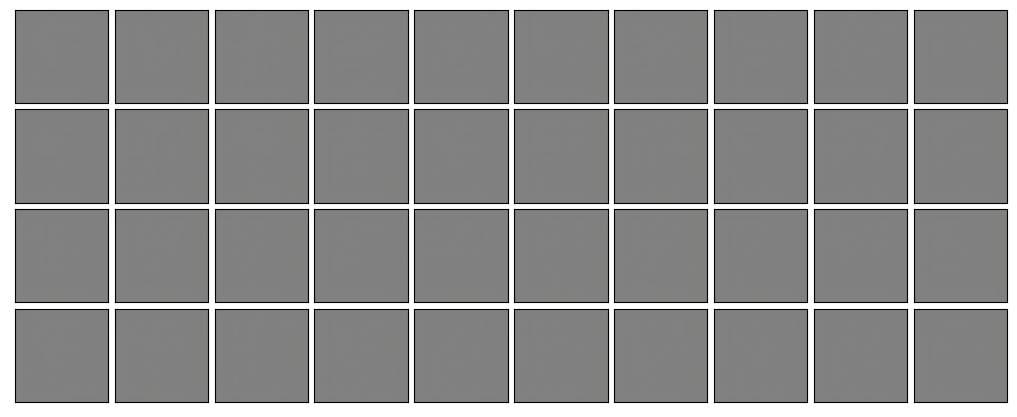

In [217]:
def plot_many_images(multibatch):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4), dpi=100)
    for i in range(10):
        for j in range(4):
            axes[j, i].imshow(multibatch[i, j].mul(0.5).add(0.5).clip(0,1).permute((1,2,0)))
            axes[j, i].set_xticks([]); axes[j, i].set_yticks([])
    fig.tight_layout(pad=0.1)

with torch.no_grad():
    T_XZ_test_fixed = T(
        torch.tensor(XZ_test_fixed, device=DEVICE).flatten(start_dim=0, end_dim=1)
    ).permute(1,2,3,0).reshape(3,16,16,BATCH_SIZE,4).permute(3,4,0,1,2).to('cpu')
plot_many_images(T_XZ_test_fixed)

We are going to use the weak kernel cost $C_{1,\gamma}$ in this experiment.

In [220]:
COST = weak_kernel_cost

# Other parameters
T_ITERS = 10
MAX_STEPS = 10000 + 1
Z_SIZE = 4
GAMMA = 0.5

❔ Now we are ready to implement the algorithm and train the networks. Before this, try to think about the following questions:
- Which properties do you want your map to preserve (e.g., color, shape, etc.)?
- Is the kernel cost $C_{1,\gamma}$ a good choice for this? Yes/No? Why?

Now implement the NOT algorithm, train the nets and see if your guess is correct.

🔎 **Remark.** The implementation will be more challenging that for 2D case. Here you will have to do some tricky tensor reshapes.

Step 10000
GAMMA 0.5
Mnist-2 images X, mapped images T(X, Z), unpaired Mnist-3 images Y


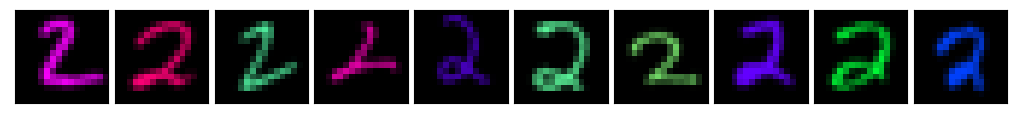

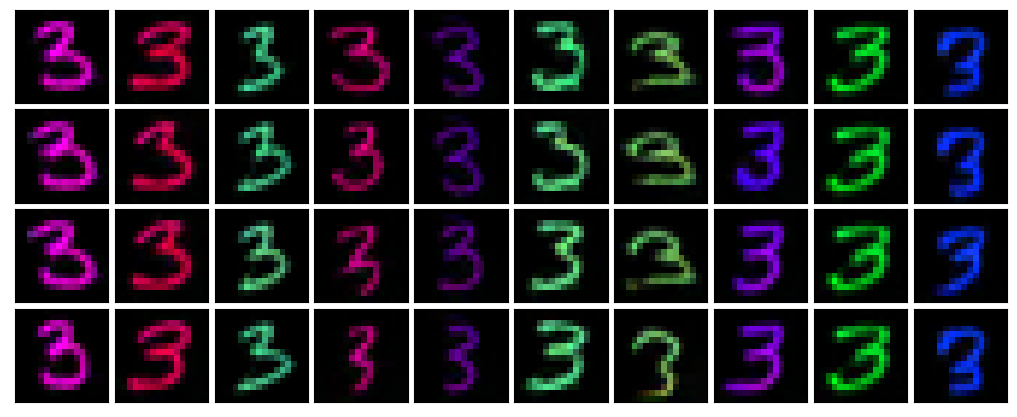

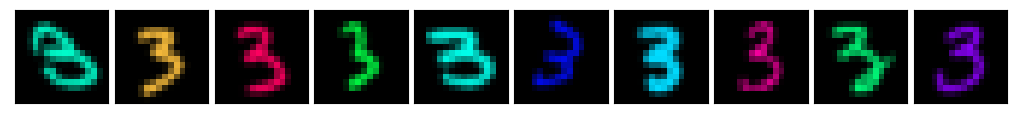

In [223]:
# NOT algorithm
for step in tqdm(range(MAX_STEPS)):
    T.train(True); f.eval()
    for t_iter in range(T_ITERS):
        # Sample X, Z
        X = sample_mnist_2().to(DEVICE) # (bs, 3, 16, 16)
        Z = torch.randn(BATCH_SIZE, Z_SIZE, 1, 16, 16, device=DEVICE)  # (bs, z_size, 1, 16, 16)

        # Get T_XZ
        XZ = torch.cat([X[:,None].repeat(1,Z_SIZE,1,1,1), Z], dim=2) # (bs, z_size, 3+1, 16, 16)
        T_XZ = # <<< your code here >>> # (bs, z_size, 3, 16, 16)

        # Compute the loss for T
        T_loss = # <<< your code here >>>
        T_opt.zero_grad(); T_loss.backward(); T_opt.step()

    # f optimization
    T.eval(); f.train(True)
    # Sample X, Y, Z
    X = sample_mnist_2().to(DEVICE) # (bs, 3, 16, 16)
    Z = torch.randn(BATCH_SIZE, Z_SIZE, 1, 16, 16, device=DEVICE)  # (bs, z_size, 1, 16, 16)
    Y = sample_mnist_3().to(DEVICE) # (bs, 3, 16, 16)

    # Get T_XZ
    XZ = # <<< your code here >>> # (bs, z_size, 3+1, 16, 16)
    T_XZ = T(
        XZ.flatten(start_dim=0, end_dim=1)
    ).permute(1,2,3,0).reshape(3,16,16,BATCH_SIZE,Z_SIZE).permute(3,4,0,1,2) # (bs, z_size, 3, 16, 16)

    # Compute the loss for f
    f_loss = # <<< your code here >>>
    f_opt.zero_grad(); f_loss.backward(); f_opt.step()

    if step % 200 == 0:
        clear_output(wait=True)
        print("Step", step)
        print("GAMMA", GAMMA)

        # The code for plotting the results
        with torch.no_grad():
            T_XZ_test_fixed = T(
                torch.tensor(XZ_test_fixed, device=DEVICE).flatten(start_dim=0, end_dim=1)
            ).permute(1,2,3,0).reshape(3,16,16,BATCH_SIZE,Z_SIZE).permute(3,4,0,1,2).to('cpu')
        print('Mnist-2 images X, mapped images T(X, Z), unpaired Mnist-3 images Y')
        plot_images(X_test_fixed)
        plot_many_images(T_XZ_test_fixed)
        plot_images(Y_test_fixed)
        plt.show()

❔ After obtaining the results, think about the following questions:
- Do the output images resemble the shape/details/color of the input images (a.k.a. image content)?
- Does the weak kernel cost turn to be a good choice for this pair of datasets? Yes/No? Why?

❔ Now try varying the parameter $\gamma$:
- Test $\gamma=0$. You will see the *conditional collapse*, i.e., no diversity in generated samples $T(x,z)$.
- Test $\gamma=2.5$. The output image will barely represent the input image.

Is this behavior expected? Yes/no? Think why?